In [1]:
from dependencies import *
cpidata = pd.read_excel('cpidata.xls',sheet_name='Sheet2')

a = pd.read_stata('table2_1.dta')
b = pd.read_stata('table2_2.dta')
c = pd.read_stata('table3.dta')
d = pd.read_stata('table4.dta')

data = pd.read_stata('table2_1.dta')
data = data.merge(pd.read_stata('table2_2.dta'),on=['month','year','type_fund'])
data = data.merge(pd.read_stata('table3.dta'),on=['month','year','type_fund'])
data = data.merge(pd.read_stata('table4.dta'),on=['month','year','type_fund'])

data['month'] = ['January' if x == 'Janurary' else x for x in data['month']]
data['monthyear'] = [a+str(b) for a,b in zip(data['month'].values,data['year'].values)]
data['date'] = pd.to_datetime(data['monthyear'],infer_datetime_format=True)

data = data.merge(cpidata,on=['date'])
data = data.sort_values(['date','type_fund'])

money_vars = ['new_open_amt', 'new_closed_amt', 'new_interval_amt', 'new_assured_amt', 'exi_open_amt', 'exi_closed_amt', 'exi_interval_amt', 'exi_assured_amt', 'open_red', 'closed_red', 'interval_red', 'assured_re', 'open_aum', 'closed_aum', 'interval_aum', 'assured_aum']



data['new_open_amt'] = data['new_open_amt'].fillna(1)

In [2]:
a1 = [x and y for x,y in zip(data['date'] == 'January2008',data['type_fund'] == 2)]
a2 = [x and y for x,y in zip(data['date'] > 'January2008',data['type_fund'] == 2)]
closednumsum = np.sum(data.loc[a2]['new_closed_no'])
#print('Adding closed num sum', closednumsum)
data.loc[a1,'new_closed_no'] += closednumsum
data.loc[a2,'new_closed_no'] = 0
closedamtsum = np.sum(data.loc[a2]['new_closed_amt'])
#print('Adding closed Amount sum', closedamtsum)
data.loc[a1,'new_closed_amt'] += 4656.147
#data.loc[a1,'new_closed_amt'] += closedamtsum
data.loc[a2,'new_closed_amt'] = 0

In [3]:
for mvar in money_vars:
    data[mvar] = ((data[mvar]/data['cpi9'])*10)/(46.235)

    
data['net_exi_open_amt'] = data['new_open_amt'].values + data['exi_open_amt'].values - data['open_red'].values
data['net_exi_closed_amt'] = data['new_closed_amt'].values + data['exi_closed_amt'].values - data['closed_red'].values

In [4]:
sensexdata = pd.read_stata('sensex_use.dta')
sensexdata['date'] = pd.to_datetime(sensexdata['month_year'],infer_datetime_format=True)
sensexdata  = sensexdata.set_index('date')
sensexdata['sensex_return1'] = sensexdata['sensex_return'].shift(1).values
sensexdata['sensex_return3'] = ((1+sensexdata['sensex_return'].shift(1).values)*(1+sensexdata['sensex_return'].shift(2).values)*(1+sensexdata['sensex_return'].shift(3).values))-1
#sensexdata['sensex_return1'] = sensexdata['sensex_return'].values
#sensexdata['sensex_return3'] = ((1+sensexdata['sensex_return'].values)*(1+sensexdata['sensex_return'].shift(1).values)*(1+sensexdata['sensex_return'].shift(2).values))-1

sensexdata = sensexdata.reset_index()
sensexdata = sensexdata.drop(columns=['month_year'])

In [5]:
bibordata = pd.read_stata('bibordata.dta')
bibordata['date'] = pd.to_datetime(bibordata['month_year'],infer_datetime_format=True)
bibordata = bibordata.drop(columns=['month_year'])

In [6]:
data = data.merge(sensexdata,on=['date'])
data = data.merge(bibordata,on=['date'],how='left')

In [7]:
maindata = data[['date', 'type_fund', 'new_open_no', 'net_exi_open_amt' ,'new_closed_no', 'net_exi_closed_amt', 'new_interval_no', 'new_interval_amt', 'new_assured_no', 'new_assured_amt','sensex_return','sensex_return1','sensex_return3','bid']]
#maindata = data[['date', 'type_fund', 'new_open_no', 'new_open_amt' ,'new_closed_no', 'new_closed_amt', 'new_interval_no', 'new_interval_amt', 'new_assured_no', 'new_assured_amt','sensex_return','sensex_return1','sensex_return3','bid']]
maindata.columns = ['date', 'type_fund', 'starts1', 'amount1', 'starts2', 'amount2', 'starts3', 'amount3', 'starts4', 'amount4','sensex_return','sensex_return1','sensex_return3','bid']

In [8]:
mainlong = pd.wide_to_long(maindata,stubnames = ['starts','amount'], i=['date','type_fund'],j='structure')
mainlong = mainlong.reset_index()

In [9]:
mainlong = mainlong.sort_values(['date','type_fund'])

In [10]:
mainlong['equity'] = 0
mainlong.loc[mainlong['type_fund'] == 2,'equity']  = 1

In [11]:
mainlong['postdum'] = 0
mainlong.loc[mainlong['date'] > 'January2008','postdum']  = 1

In [12]:
mainlong['regime1'] = 0
mainlong.loc[mainlong['date'] < 'April2006','regime1']  = 1
mainlong['regime2'] = 0
mainlong.loc[ [a and b for a,b in zip(mainlong['date'] >= 'April2006',mainlong['date'] <= 'January2008')],'regime2']  = 1
mainlong['regime3'] = 0
mainlong.loc[mainlong['date'] > 'January2008','regime3']  = 1

In [13]:
mainlong['closed'] = 0
mainlong.loc[mainlong['structure'] == 2,'closed']  = 1

In [14]:
mainlong['closed_regime1'] = mainlong['closed'] * mainlong['regime1']
mainlong['closed_regime2'] = mainlong['closed'] * mainlong['regime2']
mainlong['closed_regime3'] = mainlong['closed'] * mainlong['regime3']

In [15]:
from linearmodels import PanelOLS
import math
temp = mainlong[mainlong['type_fund']==2]
temp = temp[[a or b for a,b in zip(temp['structure']==2,temp['structure']==1)]]
basedate = temp['date'].values[0]
temp['time_trend'] = [math.floor(x.days/30.2) for x in (temp['date'] - basedate)]
temp = temp[['time_trend','structure', 'date','amount','starts' ,'sensex_return','sensex_return1' , 'sensex_return3', 'regime2', 'regime3', 'closed' , 'closed_regime2' , 'closed_regime3']]
temp = temp.set_index(['structure', 'date'])
temp.describe()

,time_trend,amount,starts,sensex_return,sensex_return1,sensex_return3,regime2,regime3,closed,closed_regime2,closed_regime3
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,59.500000,133.724077,1.129167,0.010804,0.010251,0.032069,0.183333,0.166667,0.500000,0.091667,0.083333
std,34.712206,404.221761,1.812319,0.079741,0.080110,0.160064,0.387748,0.373457,0.501045,0.289158,0.276963
min,0.000000,-702.554740,0.000000,-0.247461,-0.247461,-0.401967,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.750000,-6.575305,0.000000,-0.038970,-0.041630,-0.090966,0.000000,0.000000,0.000000,0.000000,0.000000
50%,59.500000,0.000000,0.000000,0.016898,0.016898,0.003803,0.000000,0.000000,0.500000,0.000000,0.000000
75%,89.250000,136.660650,2.000000,0.066283,0.066283,0.146174,0.000000,0.000000,1.000000,0.000000,0.000000
max,119.000000,2730.089463,12.000000,0.256979,0.256979,0.629468,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
formula1 = 'starts ~ regime2+ closed+ closed_regime2 + 1 '
formula2 = 'starts ~ regime2+ regime3 + closed+ closed_regime2 + closed_regime3 + 1 '
formula3 = 'starts ~ time_trend+ regime2+ regime3 + closed+ closed_regime2 + closed_regime3 + 1 '
formula4 = 'starts ~ time_trend+ sensex_return1 + sensex_return3+ regime2+ regime3 + closed+ closed_regime2 + closed_regime3 + 1 '

In [17]:
mod = PanelOLS.from_formula(formula1, temp)
res1 = mod.fit(cov_type='clustered')
print(res1)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 starts   R-squared:                        0.2602
Estimator:                   PanelOLS   R-squared (Between):              1.0000
No. Observations:                 240   R-squared (Within):               0.1127
Date:                Sat, May 11 2019   R-squared (Overall):              0.2602
Time:                        00:28:47   Log-likelihood                   -446.58
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      27.673
Entities:                           2   P-value                           0.0000
Avg Obs:                       120.00   Distribution:                   F(3,236)
Min Obs:                       120.00                                           
Max Obs:                       120.00   F-statistic (robust):             40.948
                            

In [18]:
mod = PanelOLS.from_formula(formula2, temp)
res1 = mod.fit(cov_type='clustered')
print(res1)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 starts   R-squared:                        0.2626
Estimator:                   PanelOLS   R-squared (Between):              1.0000
No. Observations:                 240   R-squared (Within):               0.1155
Date:                Sat, May 11 2019   R-squared (Overall):              0.2626
Time:                        00:28:48   Log-likelihood                   -446.19
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      16.668
Entities:                           2   P-value                           0.0000
Avg Obs:                       120.00   Distribution:                   F(5,234)
Min Obs:                       120.00                                           
Max Obs:                       120.00   F-statistic (robust):             27.534
                            

In [19]:
mod = PanelOLS.from_formula(formula3, temp)
res1 = mod.fit(cov_type='clustered')
print(res1)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 starts   R-squared:                        0.3175
Estimator:                   PanelOLS   R-squared (Between):              1.0000
No. Observations:                 240   R-squared (Within):               0.1814
Date:                Sat, May 11 2019   R-squared (Overall):              0.3175
Time:                        00:28:48   Log-likelihood                   -436.91
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      18.065
Entities:                           2   P-value                           0.0000
Avg Obs:                       120.00   Distribution:                   F(6,233)
Min Obs:                       120.00                                           
Max Obs:                       120.00   F-statistic (robust):             24.153
                            

In [20]:
mod = PanelOLS.from_formula(formula4, temp)
res1 = mod.fit(cov_type='clustered')
print(res1)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 starts   R-squared:                        0.3244
Estimator:                   PanelOLS   R-squared (Between):              1.0000
No. Observations:                 240   R-squared (Within):               0.1897
Date:                Sat, May 11 2019   R-squared (Overall):              0.3244
Time:                        00:28:49   Log-likelihood                   -435.68
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      13.867
Entities:                           2   P-value                           0.0000
Avg Obs:                       120.00   Distribution:                   F(8,231)
Min Obs:                       120.00                                           
Max Obs:                       120.00   F-statistic (robust):             17.571
                            

In [21]:
temp = temp.reset_index()
leadlagdates = ['November2005','December2005','January2006','February2006','March2006','February2008','March2008','April2008','May2008','June2008']
for date in leadlagdates:
    temp[date] = 0
    temp.loc[temp['date'] == date ,date]  = 1
    temp['closed_'+date] = temp[date] * temp['closed']
temp = temp.set_index(['structure', 'date'])

In [22]:
formula5 = 'starts ~ time_trend+ sensex_return1 + sensex_return3+ regime2+ regime3 + closed+ closed_regime2 + closed_regime3 +  closed_November2005 + closed_December2005 + closed_January2006 + closed_February2006 + closed_March2006 + closed_February2008 + closed_March2008 + closed_April2008 + closed_May2008 + closed_June2008 + 1 '

In [23]:
mod = PanelOLS.from_formula(formula5, temp)
res1 = mod.fit(cov_type='clustered')
print(res1)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 starts   R-squared:                        0.3289
Estimator:                   PanelOLS   R-squared (Between):              1.0000
No. Observations:                 240   R-squared (Within):               0.1950
Date:                Sat, May 11 2019   R-squared (Overall):              0.3289
Time:                        00:28:55   Log-likelihood                   -434.89
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6.0171
Entities:                           2   P-value                           0.0000
Avg Obs:                       120.00   Distribution:                  F(18,221)
Min Obs:                       120.00                                           
Max Obs:                       120.00   F-statistic (robust):         -5.176e+15
                            

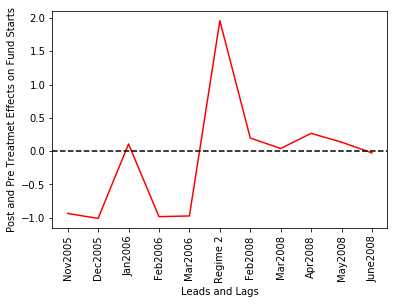

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
labels = ['Nov2005','Dec2005','Jan2006','Feb2006','Mar2006','Regime 2','Feb2008','Mar2008','Apr2008','May2008','June2008']
coeffs = [-0.9363,-1.0111,0.1078,-0.9844,-0.9741,1.9606,0.1972,0.0403,0.2678,0.1355,-0.0268]
plt.plot(labels,coeffs,'r-')
plt.axhline(0,color='black',linestyle='--')
plt.xlabel('Leads and Lags')
plt.ylabel('Post and Pre Treatmet Effects on Fund Starts')
plt.xticks(rotation='vertical')
plt.show()